In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import time
from joblib import load,dump

from tensorflow import keras

from useful_functions import load_transform_split, color_scatter, plot_performance, evaluate_model, get_averaged_trend

plt.rcParams.update({
                     'xtick.direction':'in',
                     'xtick.top':True,
                     'xtick.bottom':True,
                     'ytick.direction':'in',
                     'ytick.right':True,
                     'ytick.left':True,
})

In [3]:
X_train,X_test,y_train,y_test,pipeline = load_transform_split(target='DROPOUT_N',
                                                              expand=False,
                                                              clean=True,
                                                              split=0.2,
                                                              return_pipeline=True,
                                                              fmt='pandas',
                                                              random_state=42)

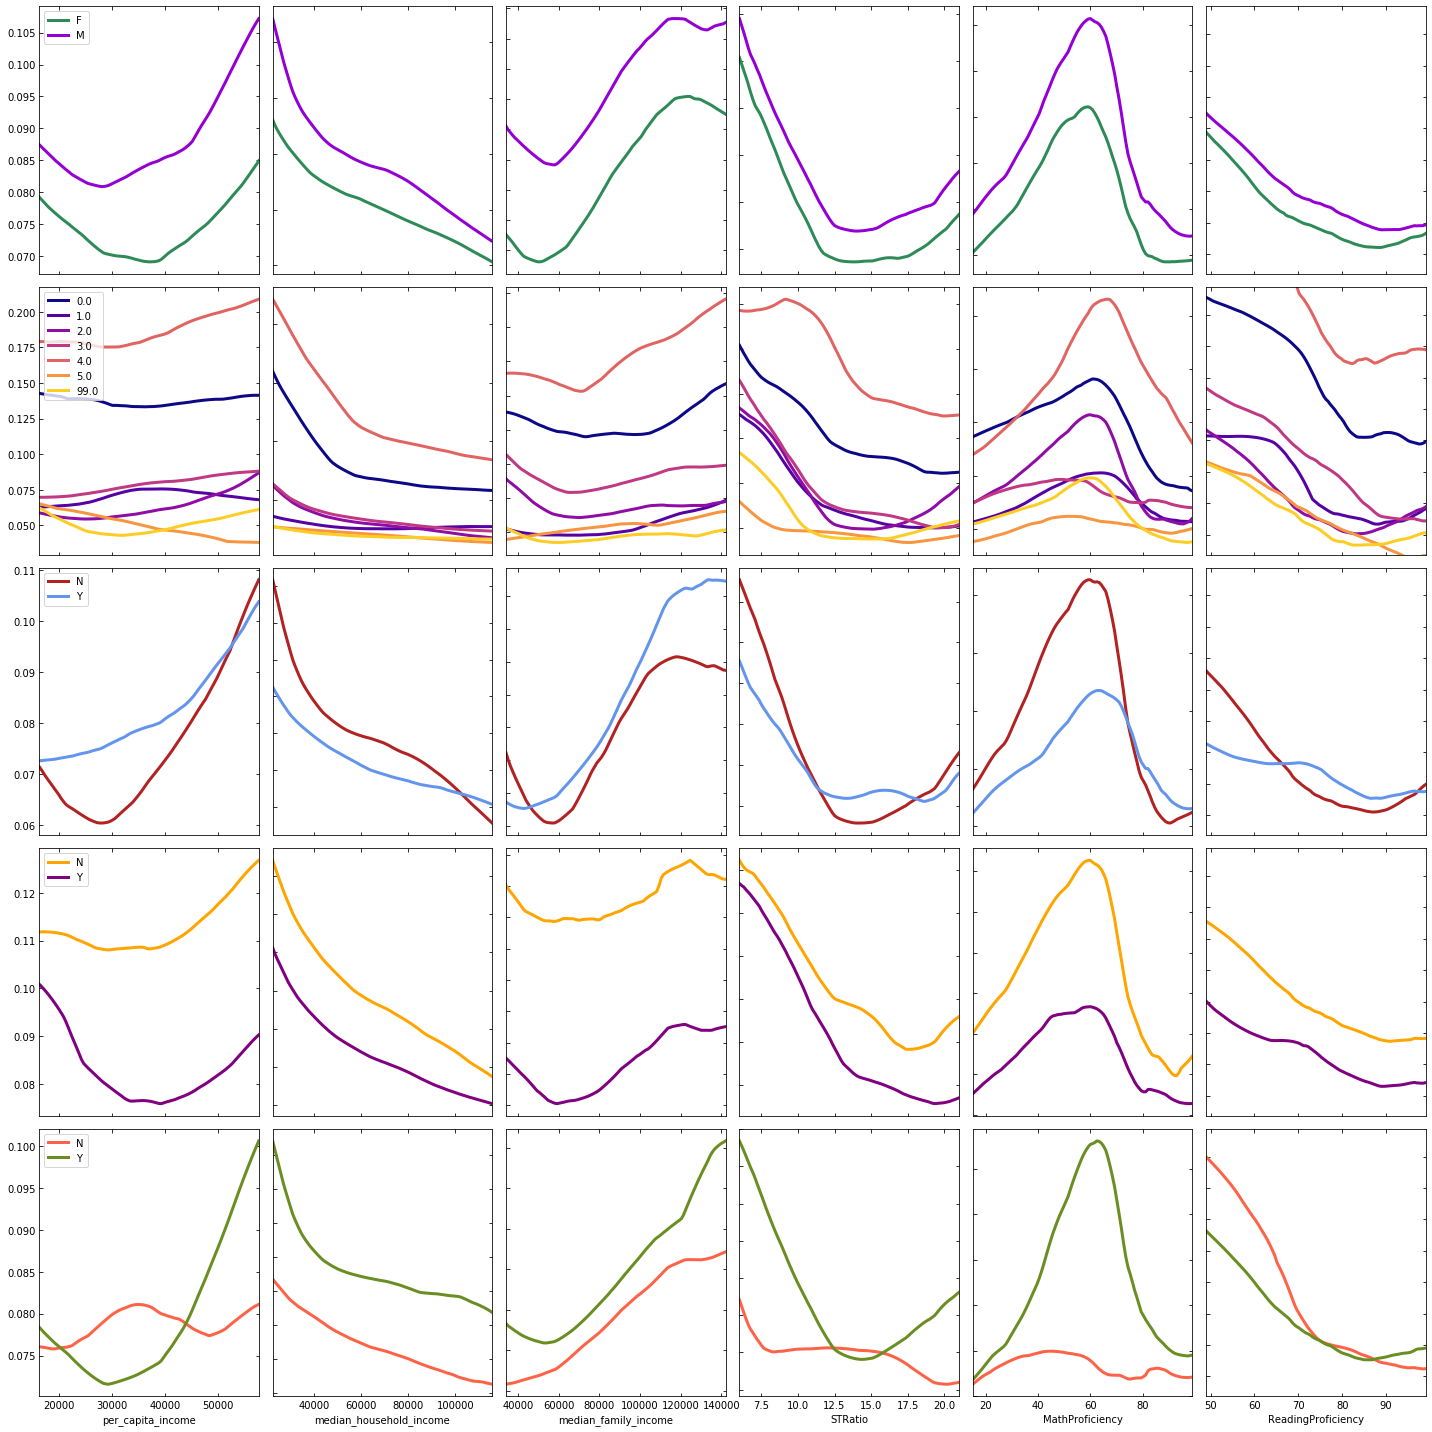

In [11]:
def feature_plot(model,pipeline):
    X,_ = load_transform_split(target=None,clean=False,fmt='pandas')
    num_feats=["per_capita_income",
               "median_household_income",
               "median_family_income",
               #"StudentNumber",
               "STRatio",
               "MathProficiency",
               "ReadingProficiency"]
    cat_feats=["GENDER",
               "FEDERAL_RACE_CODE",
               "DISABILITY_FLAG",
               "DISADVANTAGED_FLAG",
               "LEP_FLAG"]
    race_code_cmap = 'plasma'
    cm = plt.get_cmap(race_code_cmap)
    colors = {"GENDER":{'M':'darkviolet','F':'seagreen'},
              "FEDERAL_RACE_CODE":{0:cm(0.),1:cm(0.15),2:cm(0.3),3:cm(0.45),4:cm(0.6),5:cm(0.75),99:cm(0.9)},
              "DISABILITY_FLAG":{'Y':'cornflowerblue','N':'firebrick'},
              "DISADVANTAGED_FLAG":{'Y':'purple','N':'orange'},
              "LEP_FLAG":{'Y':'olivedrab','N':'tomato'}}
    cat_opts = {k:sorted(pd.unique(X[k])) for k in cat_feats}
    num_rngs = {k:[np.min(X[k]),np.max(X[k])] for k in num_feats}
    fig,axs = plt.subplots(len(cat_feats),len(num_feats),figsize=(20,20))
    cohort_arr = [5,15,50,100]
    for j,cf in enumerate(cat_feats):
        ymax=0
        ymin=np.inf
        for i,nf in enumerate(num_feats):
            if cf is None:
                continue
            for cval in cat_opts[cf]:
                drop_arrs = []
                for cohort_size in cohort_arr:
                    feat_arr,drop_arr = get_averaged_trend(model,pipeline,feat=nf,lo=num_rngs[nf][0],hi=num_rngs[nf][1],
                                              nsamples=3,COHORT_CNT=cohort_size,seed=42,**{cf:cval})
                    drop_arrs.append(drop_arr/cohort_size)
                drop_arrs = np.array(drop_arrs)
                mean_drop_arr = np.mean(drop_arrs,axis=0)
                axs[j,i].plot(feat_arr,mean_drop_arr,color=colors[cf][cval],lw=3,label=str(cval))
                if np.max(mean_drop_arr) > ymax: ymax = np.max(mean_drop_arr)
                if np.min(mean_drop_arr) < ymin: ymin = np.min(mean_drop_arr)
                axs[j,i].set_xlim(num_rngs[nf][0],num_rngs[nf][1])
                if i>0:
                    axs[j,i].set_yticklabels([])
                else:
                    axs[j,i].legend(loc=2)
                if cf != cat_feats[-1]:
                    axs[j,i].set_xticklabels([])
                else:
                    axs[j,i].set_xlabel(nf)
        for j,cf in enumerate(cat_feats):
            axs[j,i].set_ylim(0.8*ymin,1.1*ymax)
    plt.tight_layout()
    fig.savefig("thing.png")

#model = load('saved_models/best_weighted_rfr_trial2.joblib')
model = keras.models.load_model('saved_models/weighted_neuralnet_attempt2.h5')
feature_plot(model,pipeline)

In [62]:
plt.savefig("thing.png")

<Figure size 432x288 with 0 Axes>